In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
# sys.path.append(os.path.abspath('..'))
os.chdir(os.path.abspath('..'))

### Old stuff

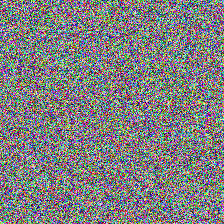

In [12]:
from PIL import Image
import numpy as np

image = np.random.randint(0,255, size=[224,224,3], dtype=np.uint8)
im = Image.fromarray(np.uint8(image))
im

In [2]:
# load model
from dinov2.train.train import *
from argparse import Namespace

args = Namespace(config_file='../dinov2/configs/debug.yaml', output_dir='/home/lewaldm/code/out')
args = get_args_parser(add_help=True).parse_args([], namespace=args)
cfg = setup(args)
model = SSLMetaArch(cfg).to(torch.device("cuda"))
checkpointer = Checkpointer(model, cfg.train.output_dir)

/home/lewaldm/code/PanOpticOn/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/lewaldm/code/PanOpticOn/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/lewaldm/code/PanOpticOn/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


I20240924 12:02:59 814259 dinov2 config.py:59] git:
  sha: 6fd52358ec8240f2a2293ce120a42853bd4d2b56, status: has uncommitted changes, branch: dino

I20240924 12:02:59 814259 dinov2 config.py:60] config_file: ../dinov2/configs/debug.yaml
eval: 
eval_only: False
no_resume: False
opts: ['train.output_dir=/home/lewaldm/code/out']
output_dir: /home/lewaldm/code/out
I20240924 12:02:59 814259 dinov2 config.py:26] sqrt scaling learning rate; base: 0.004, new: 0.00021650635094610965
I20240924 12:02:59 814259 dinov2 config.py:33] MODEL:
  WEIGHTS: ''
compute_precision:
  grad_scaler: true
  teacher:
    backbone:
      sharding_strategy: NO_SHARD
      mixed_precision:
        param_dtype: fp16
        reduce_dtype: fp16
        buffer_dtype: fp32
    dino_head:
      sharding_strategy: NO_SHARD
      mixed_precision:
        param_dtype: fp16
        reduce_dtype: fp16
        buffer_dtype: fp32
    ibot_head:
      sharding_strategy: NO_SHARD
      mixed_precision:
        param_dtype: fp16
  

: 

In [14]:
def pprint(name, model):
    print(f'{name}: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M')

pprint('model', model)
pprint('student', model.student)
pprint('teacher', model.teacher)


model: 172.2M
student: 86.1M
teacher: 86.1M


In [4]:
from omegaconf import OmegaConf

cfg = OmegaConf.load('../dinov2/configs/debug.yaml')

In [11]:
cfg.train.get('batch_size_per_gpu')

128

In [11]:
from dinov2.data.datasets.fmow import FmowDataset
ds = FmowDataset('/data/panopticon/datasets/', 'fmow/metadata_v2/fmow_iwm_onid_val.parquet')

In [13]:
ds.M = 3
for i in range(10):
    out = ds[i]
    for j in range(len(out['ds_names'])):
        print(out['ds_names'][j], out['imgs'][j].shape, out['gsds'][j].items())
    print()

/home/lewaldm/miniforge3/envs/dinov2/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


fmow_rgb torch.Size([3, 7107, 7453]) tensor(0.6812)
fmow_rgb torch.Size([3, 9388, 9844]) tensor(0.4280)
fmow_rgb torch.Size([3, 7227, 7577]) tensor(0.6697)

fmow_rgb torch.Size([3, 6481, 9923]) tensor(0.4234)
fmow_s2 torch.Size([13, 328, 500]) tensor(10.)
fmow_wv23 torch.Size([8, 2113, 3235]) tensor(1.5520)

fmow_s2 torch.Size([13, 482, 501]) tensor(10.)
fmow_rgb torch.Size([3, 8152, 8480]) tensor(0.5873)
fmow_wv23 torch.Size([8, 3286, 3418]) tensor(1.4793)

fmow_wv23 torch.Size([8, 2413, 2397]) tensor(2.0681)
fmow_rgb torch.Size([3, 8417, 8363]) tensor(0.5956)
fmow_wv23 torch.Size([8, 2106, 2093]) tensor(2.3895)

fmow_rgb torch.Size([3, 9323, 9365]) tensor(0.4889)
fmow_s2 torch.Size([13, 499, 501]) tensor(10.)
fmow_s2 torch.Size([13, 499, 501]) tensor(10.)

fmow_rgb torch.Size([3, 7367, 8449]) tensor(0.5786)
fmow_s2 torch.Size([13, 437, 501]) tensor(10.)
fmow_s2 torch.Size([13, 437, 501]) tensor(10.)

fmow_wv23 torch.Size([8, 2940, 3390]) tensor(1.4832)
fmow_rgb torch.Size([3, 9248, 1

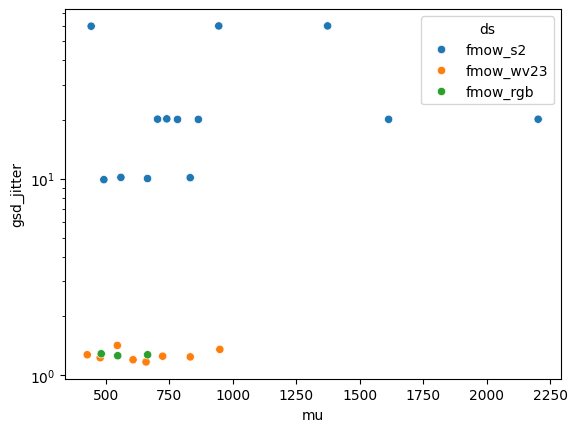

In [5]:
from dinov2.utils.data import plot_ds

plot_ds('fmow_s2','fmow_wv23','fmow_rgb')

In [35]:
from dinov2.utils.data import getimgsatl

id = '2810_4596'

print('s2')
dir = 'S2A_MSIL1C_20220905T134721_N0400_R024_T21KWS_20220905T185126'
out = getimgsatl(id, dir, 's2')
for k, v in out.items():
    print(k, v.shape)

print('ls')
out = getimgsatl(id, '2022-01', 'ls')
for k, v in out.items():
    print(k, v.shape)

s2
tci torch.Size([3, 512, 512])
b05 torch.Size([1, 512, 512])
b06 torch.Size([1, 512, 512])
b07 torch.Size([1, 512, 512])
b08 torch.Size([1, 512, 512])
b11 torch.Size([1, 512, 512])
b12 torch.Size([1, 512, 512])
ls
b1 torch.Size([1, 256, 256])
b2 torch.Size([1, 256, 256])
b3 torch.Size([1, 256, 256])
b4 torch.Size([1, 256, 256])
b5 torch.Size([1, 256, 256])
b6 torch.Size([1, 256, 256])
b7 torch.Size([1, 256, 256])
b8 torch.Size([1, 512, 512])
b9 torch.Size([1, 256, 256])
b10 torch.Size([1, 64, 64])
b11 torch.Size([1, 64, 64])


In [73]:
from dinov2.data.datasets.fmow import FmowDataset
# ds = FmowDataset('/data/panopticon/datasets/', 'fmow/metadata_v2/fmow_iwm_onid_train_val_presorted.parquet')
ds = FmowDataset('/data/panopticon/datasets/', 'fmow/metadata_v2/fmow_iwm_onid_val.parquet', normalize=False)

i = 0
while True:
    out = ds[i]
    i += 1
    if set(out['ds_names']) == set(['fmow_s2', 'fmow_rgb']):
        break
print(out['ds_names'][0], out['imgs'][0].shape)
print(out['ds_names'][1], out['imgs'][1].shape)

[autoreload of dinov2.data.datasets.fmow failed: Traceback (most recent call last):
  File "/home/lewaldm/miniforge3/envs/dinov2/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/lewaldm/miniforge3/envs/dinov2/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/lewaldm/miniforge3/envs/dinov2/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/lewaldm/miniforge3/envs/dinov2/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 335, in update_class
    if (old_obj == new_obj) is True:
RuntimeError: Boolean value of Tensor with more than one value is ambiguous
]
/home/lewaldm/miniforge3/envs/dinov2/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity

fmow_rgb torch.Size([3, 9388, 9844])
fmow_s2 torch.Size([13, 478, 501])


(0, 1, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


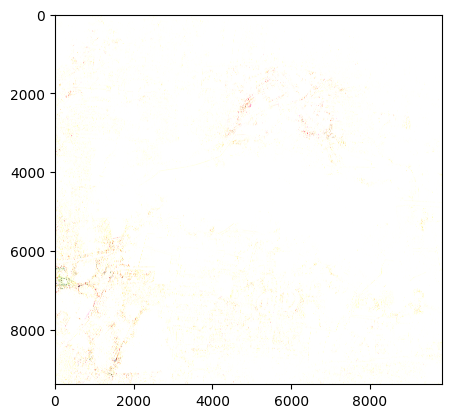

(0, 2, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


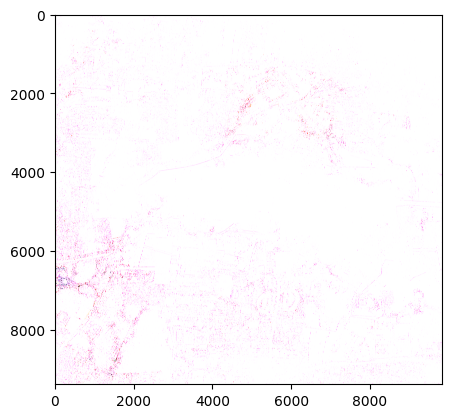

(1, 0, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


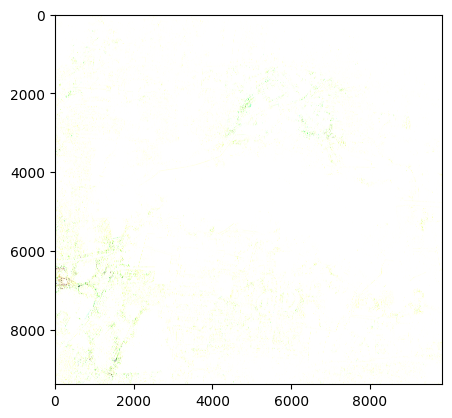

(1, 2, 0)


KeyboardInterrupt: 

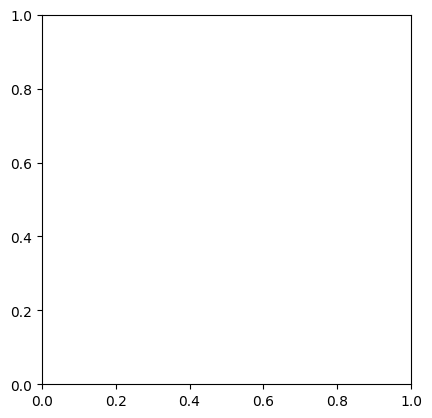

In [74]:
import matplotlib.pyplot as plt
from itertools import permutations

for p in permutations([0,1,2]):
    print(p)
    plt.imshow(out['imgs'][0][list(p)].permute(1,2,0))    
    plt.show()



/home/lewaldm/miniforge3/envs/dinov2/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5351477..2.0772014].


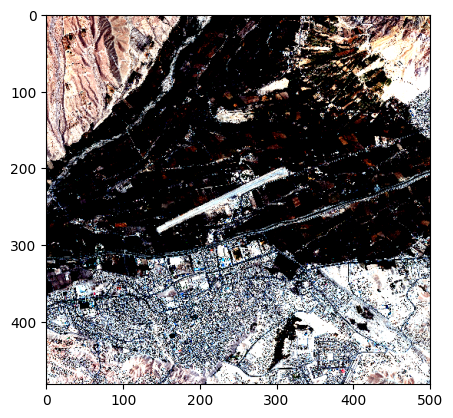

In [71]:
from torchvision.transforms.functional import resize

x = out['imgs'][0]
x = resize(x, [482, 501])
plt.imshow(x.permute(1,2,0))   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.325905..7.1446486].


(1, 2, 3)


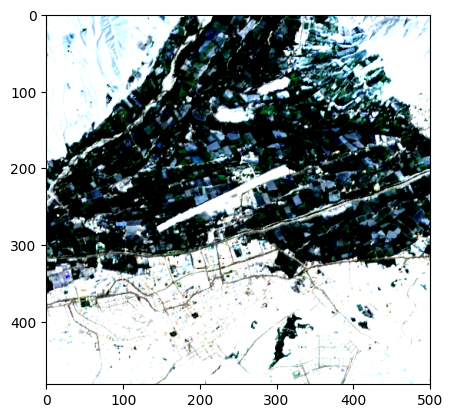

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.325905..7.1446486].


(1, 3, 2)


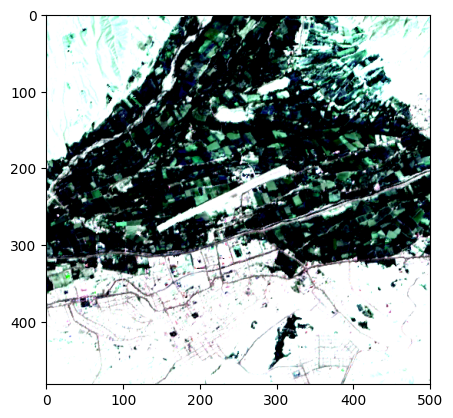

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.325905..7.1446486].


(2, 1, 3)


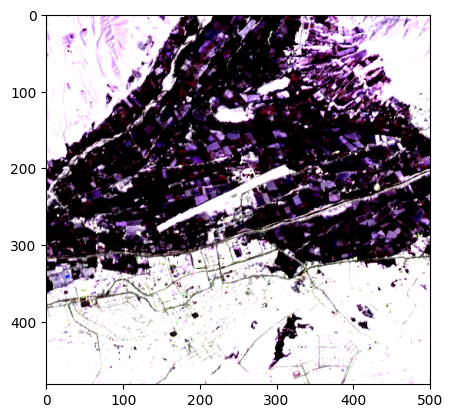

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.325905..7.1446486].


(2, 3, 1)


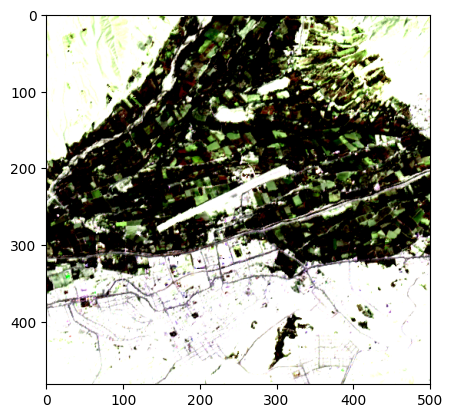

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.325905..7.1446486].


(3, 1, 2)


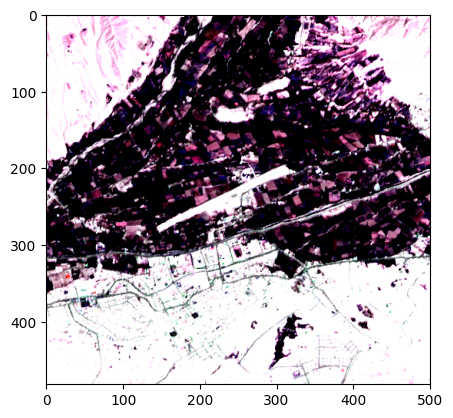

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.325905..7.1446486].


(3, 2, 1)


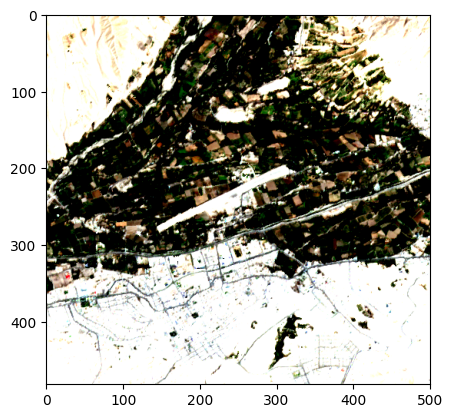

In [65]:
from itertools import permutations

for p in permutations([1,2,3]):
    print(p)
    plt.imshow(out['imgs'][1][list(p)].permute(1,2,0))
    plt.show()


In [7]:
import torch

b = 5
sample_subset_size = 3

x = torch.arange(b).reshape(-1, 1, 1).expand(-1, 4, 2)
brange = (torch.randperm(b, device=x.device))[:sample_subset_size]
print(brange)
x_subset = x[brange]
residual = -x_subset 

x_flat = x.flatten(1)
residual = residual.flatten(1)
print(x_flat)
print(residual)

x_plus_residual = torch.index_add(x_flat, 0, brange, residual.to(dtype=x.dtype), alpha=1)
x_plus_residual

tensor([1, 0, 4])
tensor([[0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4, 4, 4]])
tensor([[-1, -1, -1, -1, -1, -1, -1, -1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [-4, -4, -4, -4, -4, -4, -4, -4]])


tensor([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3, 3],
        [0, 0, 0, 0, 0, 0, 0, 0]])

In [5]:
""" test patch embedding"""
from dinov2.models.panopticon import ChnWisePatchEmb

pe = ChnWisePatchEmb(16, 128)

x = torch.randn(3, 4, 224, 224)
pe(x).shape

torch.Size([3, 4, 196, 128])

In [24]:
""" test cross attention""" 

from dinov2.layers.attention import QueryCrossAttention

dim = 128
num_heads = 8

attn = QueryCrossAttention(dim, num_heads)

q = torch.randn(3, 2, dim)
kv = torch.randn(3, 16, dim)
attn(q, kv).shape

/home/lewaldm/code/PanOpticOn/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")


torch.Size([3, 2, 128])

In [58]:
""" benchmarking channel extraction"""
import numpy as np
import torch
import timeit

input = np.random.choice(range(100, 10000), 20)
input = np.random.choice(input, (1024,3), replace=True)
input = torch.from_numpy(input)
D = 128

def get_emb(n):
    return torch.full((D,), n).float()

# v1: map dictionary

class V1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.map = dict()
        self.weights = torch.zeros(0, D).float()

    def _fun(self,x):
        if x not in self.map:
            ctr = len(self.map)
            self.map[x] = ctr
        return self.map[x]
    
    def forward(self, input: torch.Tensor):
        keys_before = set(self.map.keys())
        input.apply_(self._fun)

        if len(self.map) > len(keys_before):
            # not strictly necessary since keys are added in order
            new_keys = set(self.map.keys()) - keys_before
            new_keys_in_order = sorted(new_keys, key=lambda x: self.map[x])
            add_weights = torch.stack([get_emb(x) for x in new_keys_in_order])

            self.weights = torch.cat([self.weights, add_weights])
        return torch.nn.functional.embedding(input, self.weights)

emb = V1()
emb.to('cuda:0')
input.to('cuda:0')

timeit.timeit(lambda: emb(input), number=1)



0.0021255428437143564

In [3]:
import torch

t = torch.tensor([1,2,3,4,5], device='cuda:0')
torch.zeros_like(t)

tensor([0, 0, 0, 0, 0], device='cuda:0')

In [4]:
img_list = [torch.full((5,), i, device='cuda:0') for i in range(5)]
print(img_list)

img = img_list[0]
img = torch.full((5,), -1, device='cuda:0')
print(img_list)

[tensor([0, 0, 0, 0, 0], device='cuda:0'), tensor([1, 1, 1, 1, 1], device='cuda:0'), tensor([2, 2, 2, 2, 2], device='cuda:0'), tensor([3, 3, 3, 3, 3], device='cuda:0'), tensor([4, 4, 4, 4, 4], device='cuda:0')]
[tensor([0, 0, 0, 0, 0], device='cuda:0'), tensor([1, 1, 1, 1, 1], device='cuda:0'), tensor([2, 2, 2, 2, 2], device='cuda:0'), tensor([3, 3, 3, 3, 3], device='cuda:0'), tensor([4, 4, 4, 4, 4], device='cuda:0')]


In [31]:
import numpy as np

np.random.randint(0,2)

0

/home/lewaldm/code/PanOpticOn/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/lewaldm/code/PanOpticOn/dinov2/layers/attention.py:28: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/lewaldm/code/PanOpticOn/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [24]:
""" compare vanilla pytorch to torch multihead attention"""

from dinov2.models.panopticon import QueryCrossAttention
import timeit
import torch

device = 'cuda:0'
dim = 128
num_heads = 8

ours = QueryCrossAttention(dim, num_heads)
current = torch.nn.MultiheadAttention(dim, num_heads, batch_first=True) 
ours.to(device)
current.to(device)

q = torch.randn(3, 196, dim, device=device)
kv = torch.randn(3, 196, dim, device=device)

print('No padding')
print(timeit.timeit(lambda: ours(q, kv), number=500))
print(timeit.timeit(lambda: current(q, kv, kv), number=500))

print('With padding')
key_padding_mask = torch.randint(0, 2, (3, 196), device=device).bool()
print(timeit.timeit(lambda: ours(q, kv, key_padding_mask), number=500))
print(timeit.timeit(lambda: current(q, kv, kv, key_padding_mask), number=500))


No padding
0.12172978883609176
0.10715180914849043
With padding
0.10286087589338422
0.12737161479890347


In [4]:
""" benchmark how long reloading the dataloader takes"""
from omegaconf import OmegaConf
from dinov2.data import SamplerType, make_data_loader, make_dataset


default_cfg = OmegaConf.create('/home/lewaldm/code/PanOpticOn/dinov2/configs/rs_ssl_default_config.yaml')
cfg = OmegaConf.load('/home/lewaldm/code/PanOpticOn/dinov2/configs/increment.yaml')
cfg = OmegaConf.merge(default_cfg, cfg)

dataset, crops_meta = make_dataset(cfg.train.dataset, with_crops_meta=True)

img_size = crops_meta["global_crops_size"]
patch_size = cfg.student.patch_size
n_tokens = (img_size // patch_size) ** 2
mask_generator = MaskingGenerator(
    input_size=(img_size // patch_size, img_size // patch_size),å
    max_num_patches=0.5 * img_size // patch_size * img_size // patch_size,
)

inputs_dtype = torch.half
start_iter = 0

collate_fn = partial(
    collate_data_and_cast,
    mask_ratio_tuple=cfg.ibot.mask_ratio_min_max,
    mask_probability=cfg.ibot.mask_sample_probability,
    n_tokens=n_tokens,
    mask_generator=mask_generator,
    dtype=inputs_dtype,
    global_smask_absolute_tuple=cfg.train.global_smask_absolute_tuple,
    local_smask_absolute_tuple=cfg.train.local_smask_absolute_tuple,
)


sampler_type = SamplerType.INFINITE
data_loader = make_data_loader(
    dataset=dataset,
    batch_size=cfg.train.batch_size_per_gpu,
    num_workers=cfg.train.num_workers,
    shuffle=True,
    seed=start_iter,  # TODO: Fix this -- cfg.train.seed
    sampler_type=sampler_type,
    sampler_advance=0,  # TODO(qas): fix this -- start_iter * cfg.train.batch_size_per_gpu,
    drop_last=cfg.train.drop_last,
    pin_memory=cfg.train.pin_memory,
    collate_fn=collate_fn,
)

/home/lewaldm/code/PanOpticOn/dinov2/data/datasets/fmow.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.chn_ids = {k: torch.tensor(v, dtype=torch.long) for k, v in chn_ids.items()}


NameError: name 'MaskingGenerator' is not defined

In [2]:
import torch

model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')

Using cache found in /home/lewaldm/.cache/torch/hub/facebookresearch_dinov2_main


In [3]:
model

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [6]:
state_dict = torch.load('/data/panopticon/other_model_ckpts/dinov2/dinov2_vitb14_pretrain.pth', map_location='cpu')
state_dict_new = dict(model=state_dict)
torch.save(state_dict_new, '/data/panopticon/other_model_ckpts/dinov2/dinov2_vitb14_pretrain_model.pth')

In [11]:
print(default_cfg)

{'MODEL': {'WEIGHTS': ''}, 'compute_precision': {'grad_scaler': True, 'teacher': {'backbone': {'sharding_strategy': 'NO_SHARD', 'mixed_precision': {'param_dtype': 'fp16', 'reduce_dtype': 'fp16', 'buffer_dtype': 'fp32'}}, 'dino_head': {'sharding_strategy': 'NO_SHARD', 'mixed_precision': {'param_dtype': 'fp16', 'reduce_dtype': 'fp16', 'buffer_dtype': 'fp32'}}, 'ibot_head': {'sharding_strategy': 'NO_SHARD', 'mixed_precision': {'param_dtype': 'fp16', 'reduce_dtype': 'fp16', 'buffer_dtype': 'fp32'}}}, 'student': {'backbone': {'sharding_strategy': 'NO_SHARD', 'mixed_precision': {'param_dtype': 'fp16', 'reduce_dtype': 'fp16', 'buffer_dtype': 'fp32'}}, 'dino_head': {'sharding_strategy': 'NO_SHARD', 'mixed_precision': {'param_dtype': 'fp16', 'reduce_dtype': 'fp32', 'buffer_dtype': 'fp32'}}, 'ibot_head': {'sharding_strategy': 'NO_SHARD', 'mixed_precision': {'param_dtype': 'fp16', 'reduce_dtype': 'fp32', 'buffer_dtype': 'fp32'}}}}, 'dino': {'loss_weight': 1.0, 'head_n_prototypes': 65536, 'head_bo

### new stuff

In [2]:
from dinov2.models.__init__ import build_model, build_model_from_cfg
from omegaconf import OmegaConf
from dinov2.utils.config import get_cfg_from_args

cfg = OmegaConf.load('/home/lewaldm/code/PanOpticOn/dinov2/configs/train1.yaml')
default_cfg = OmegaConf.load('/home/lewaldm/code/PanOpticOn/dinov2/configs/rs_ssl_default_config.yaml')
cfg = OmegaConf.merge(default_cfg, cfg)

student, teacher, embed_dim = build_model_from_cfg(cfg)


/home/lewaldm/code/PanOpticOn/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/lewaldm/code/PanOpticOn/dinov2/layers/attention.py:28: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/lewaldm/code/PanOpticOn/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
Skip loading parameter 'pos_embed' to the model due to incompatible shapes: (1, 1370, 768) in the checkpoint but (1, 197, 768) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
patch_embed.chnattnblock.attn.inproj_kv.{bias, weight}
patch_embed.chnattnblock.attn.inproj_q.{bias, weight}
patch_embed.chnattnblock.attn.proj.{bias, weight}
patch_embed.chnattnblock.ls1.gamma
patch_embed.chnattnblock.ls2.gamma
patch_embed.chnattnblock.mlp.fc1.{bias, weight

In [24]:
from dinov2.train.train import *

train_dataset, crops_meta = make_dataset(cfg.train.dataset, with_crops_meta=True)
eval_train_dataset = make_dataset(cfg.evaluation.train_dataset)
eval_val_dataset = make_dataset(cfg.evaluation.val_dataset)

here None /data/panopticon/geobench /data/panopticon/geobench/classification_v1.0
here None /data/panopticon/geobench /data/panopticon/geobench/classification_v1.0


In [13]:
from dinov2.train.train import *

inputs_dtype = torch.half
img_size = crops_meta["global_crops_size"]
patch_size = cfg.student.patch_size
n_tokens = (img_size // patch_size) ** 2
mask_generator = MaskingGenerator(
    input_size=(img_size // patch_size, img_size // patch_size),
    max_num_patches=0.5 * img_size // patch_size * img_size // patch_size,
)

collate_fn = partial(
    collate_data_and_cast,
    mask_ratio_tuple=cfg.ibot.mask_ratio_min_max,
    mask_probability=cfg.ibot.mask_sample_probability,
    n_tokens=n_tokens,
    mask_generator=mask_generator,
    dtype=inputs_dtype,
    global_smask_absolute_tuple=cfg.train.global_smask_absolute_tuple,
    local_smask_absolute_tuple=cfg.train.local_smask_absolute_tuple,
)

train_dl = make_data_loader(
    dataset=train_dataset,
    batch_size=7,
    num_workers=0,
    shuffle=False,
    sampler_type=SamplerType.EPOCH,
    collate_fn=collate_fn,
    )

val_train_dl = make_data_loader(
    dataset=eval_train_dataset,
    sampler_type=SamplerType.EPOCH,
    shuffle=False,
    drop_last=False,
    batch_size=7,
    num_workers=0,
)

In [10]:
batch = next(iter(train_dl))    
batch.keys()

dict_keys(['collated_global_crops', 'collated_local_crops', 'collated_masks', 'mask_indices_list', 'masks_weight', 'upperbound', 'n_masked_patches'])

In [30]:
from dinov2.utils.data import dict_to_device

valbatch = next(iter(val_train_dl))

teacher.to('cuda')
teacher.patch_embed.chnemb.to('cuda')
valbatch[0] = dict_to_device(valbatch[0], 'cuda')

out = teacher(valbatch[0])
print(out.shape)

ChnEmb to ('cuda',) {}
torch.Size([7, 768])


In [41]:
torch.cdist(out, out)

tensor([[0.0000, 0.0119, 0.0099, 0.0107, 0.0086, 0.0108, 0.0119],
        [0.0119, 0.0000, 0.0061, 0.0042, 0.0175, 0.0046, 0.0038],
        [0.0099, 0.0061, 0.0000, 0.0048, 0.0146, 0.0047, 0.0061],
        [0.0107, 0.0042, 0.0048, 0.0000, 0.0159, 0.0040, 0.0044],
        [0.0086, 0.0175, 0.0146, 0.0159, 0.0000, 0.0162, 0.0175],
        [0.0108, 0.0046, 0.0047, 0.0040, 0.0162, 0.0000, 0.0048],
        [0.0119, 0.0038, 0.0061, 0.0044, 0.0175, 0.0048, 0.0000]],
       device='cuda:0', grad_fn=<CdistBackward0>)

In [39]:
outpe = teacher.patch_embed(valbatch[0])
outpe.shape

torch.Size([7, 16, 768])

In [53]:
v = valbatch[0]['imgs']
mat = torch.cdist(v.flatten(1), v.flatten(1))
mat.std(), mat.std() / (mat.max() - mat.min())

(tensor(81.3026, device='cuda:0'), tensor(0.2889, device='cuda:0'))

In [52]:
mat = torch.cdist(outpe.flatten(1), outpe.flatten(1))
mat.std(), mat.std() / (mat.max() - mat.min())

(tensor(6.0386e-05, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(0.2588, device='cuda:0', grad_fn=<DivBackward0>))

tensor(-1.0817, device='cuda:0') tensor(1.8433, device='cuda:0')
tensor(0., device='cuda:0') tensor(1., device='cuda:0')


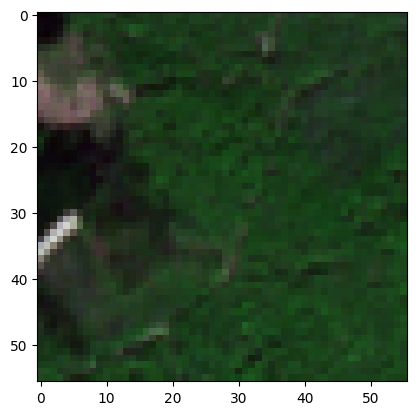

In [70]:
img = valbatch[0]['imgs'][5]

import matplotlib.pyplot as plt

print(img.min(), img.max())
img = (img - img.min()) / (img.max() - img.min())
print(img.min(), img.max())
plt.imshow(torch.index_select(img.cpu(), 0, torch.tensor([3,2,1])).permute(1,2,0))